# Exploratory Data Analysis for Recommender Systems

This notebook performs exploratory data analysis on recommendation system datasets. The goal is to understand the data and transform it into a graph-based representation (user-item-feature) that can be used for building a generic recommender system.

Dataset Links: 
- https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system?resource=download&select=movies.csv
- https://cseweb.ucsd.edu/~jmcauley/datasets.html (Steam reviews)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style('whitegrid')

## Load Kaggle MovieLens Dataset

In [2]:
movies_df = pd.read_csv('datasets/movies/movies.csv')
ratings_df = pd.read_csv('datasets/movies/ratings.csv')

print('Movies Dataset:')
display(movies_df.head())

print('Ratings Dataset:')
display(ratings_df.head())

Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Explore Movies Data

In [3]:
print('Movies Info:')
movies_df.info()

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [4]:
print('Movies Description:')
display(movies_df.describe(include='all'))

Movies Description:


,movieId,title,genres
count,62423.000000,62423,62423
unique,NaN,62325,1639
top,NaN,The Void (2016),Drama
freq,NaN,2,9056
mean,122220.387646,NaN,NaN
std,63264.744844,NaN,NaN
min,1.000000,NaN,NaN
25%,82146.500000,NaN,NaN
50%,138022.000000,NaN,NaN
75%,173222.000000,NaN,NaN


### Explore Ratings Data

In [5]:
print('Ratings Info:')
ratings_df.info()

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [6]:
print('Ratings Description:')
display(ratings_df.describe(include='all'))

Ratings Description:


,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


## Data Transformation and Knowledge Graph Creation

Here, we define a function to process the datasets into a common graph structure. This function will handle different rating scales and feature formats.

In [7]:
def transform_to_graph(ratings_df, movies_df, rating_threshold=7, dataset_name='MovieLens'):
    print(f"Original number of ratings: {len(ratings_df)}")
    recommended_df = ratings_df[ratings_df['rating'] >= rating_threshold].copy()
    print(f"Number of ratings after applying threshold (>= {rating_threshold}): {len(recommended_df)}")
    
    # Add a prefix to user and movie IDs to avoid collisions between datasets
    recommended_df['userId'] = f'{dataset_name}_user_' + recommended_df['userId'].astype(str)
    movies_df['movieId'] = f'{dataset_name}_movie_' + movies_df['movieId'].astype(str)
    recommended_df['movieId'] = f'{dataset_name}_movie_' + recommended_df['movieId'].astype(str)
    
    movies_df['genres'] = movies_df['genres'].str.split('|')
    
    user_nodes = recommended_df['userId'].unique()
    movie_nodes = movies_df['movieId'].unique()
    
    user_movie_edges = list(zip(recommended_df['userId'], recommended_df['movieId']))
    
    movie_genre_edges = []
    genre_nodes = set()
    exploded_genres = movies_df.explode('genres')
    for _, row in exploded_genres.iterrows():
        genre = row['genres']
        genre_id = f'{dataset_name}_genre_' + str(genre).lower().replace(' ', '_')
        movie_genre_edges.append((row['movieId'], genre_id))
        genre_nodes.add(genre_id)
            
    return {
        'user_nodes': list(user_nodes),
        'movie_nodes': list(movie_nodes),
        'genre_nodes': list(genre_nodes),
        'user_movie_edges': user_movie_edges,
        'movie_genre_edges': movie_genre_edges
    }

movielens_graph = transform_to_graph(ratings_df.copy(), movies_df.copy(), rating_threshold=4.0)

print(f"Number of user nodes: {len(movielens_graph['user_nodes'])}")
print(f"Number of movie nodes: {len(movielens_graph['movie_nodes'])}")
print(f"Number of genre nodes: {len(movielens_graph['genre_nodes'])}")
print(f"Number of user-movie edges: {len(movielens_graph['user_movie_edges'])}")
print(f"Number of movie-genre edges: {len(movielens_graph['movie_genre_edges'])}")

Original number of ratings: 25000095
Number of ratings after applying threshold (>= 4.0): 12452811
Number of user nodes: 162342
Number of movie nodes: 62423
Number of genre nodes: 20
Number of user-movie edges: 12452811
Number of movie-genre edges: 112307


### Visualize the Graph

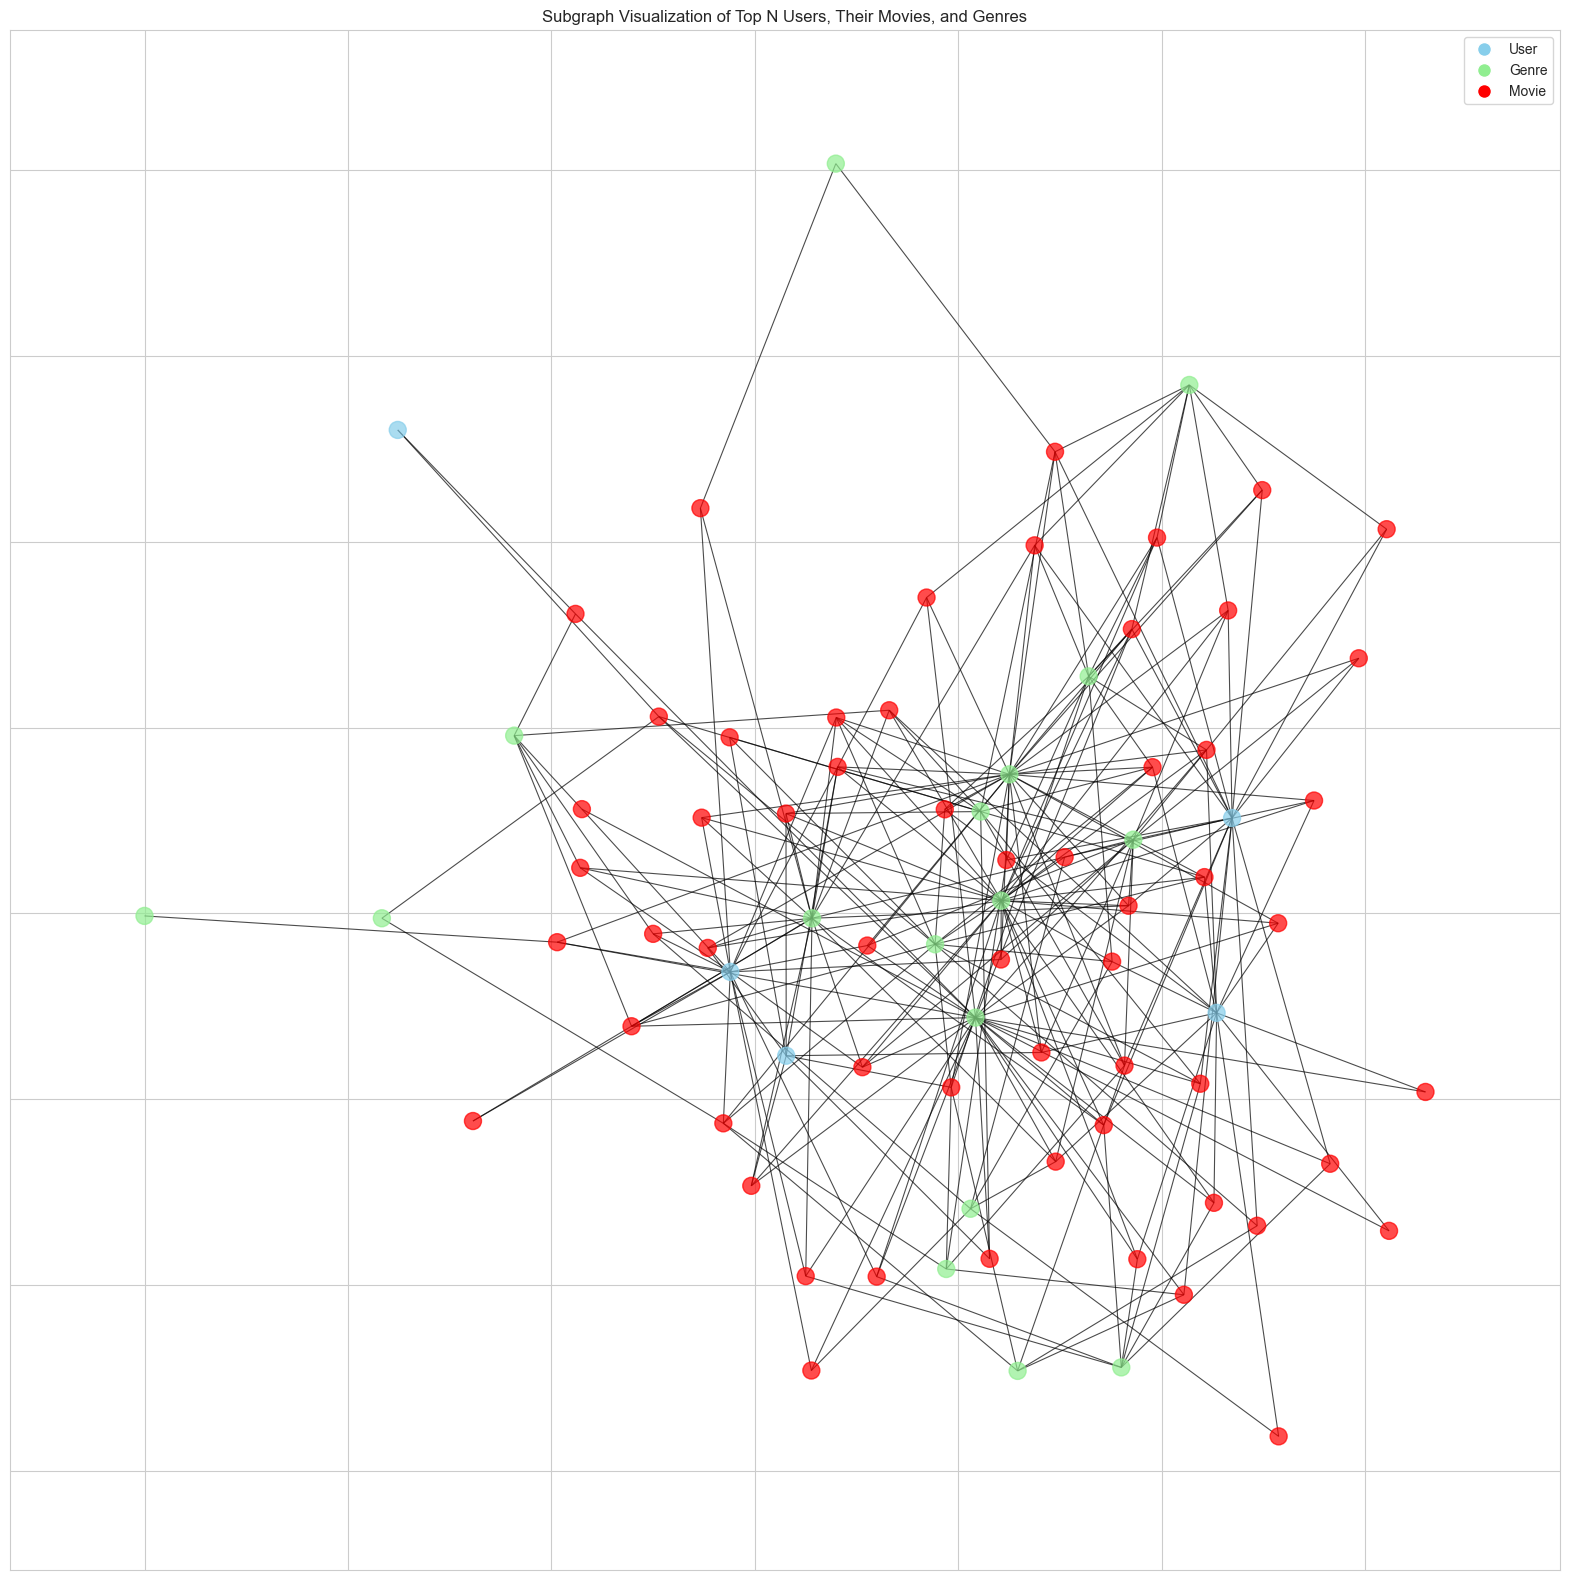

In [ ]:
import networkx as nx

def draw_subgraph(graph, users_to_add):
    G = nx.Graph()
    
    G.add_nodes_from(users_to_add, type='user')
    
    movies_to_add = set()
    user_movie_edges_subset = [edge for edge in graph['user_movie_edges'] if edge[0] in users_to_add]
    for u, m in user_movie_edges_subset:
        G.add_edge(u, m)
        movies_to_add.add(m)
    G.add_nodes_from(list(movies_to_add), type='movie')
    
    genres_to_add = set()
    movie_genre_edges_subset = [edge for edge in graph['movie_genre_edges'] if edge[0] in movies_to_add]
    for m, g in movie_genre_edges_subset:
        G.add_edge(m, g)
        genres_to_add.add(g)
    G.add_nodes_from(list(genres_to_add), type='genre')
    
    plt.figure(figsize=(20, 20))
    
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    
    node_colors = []
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        if node_type == 'user':
            node_colors.append('skyblue')
        elif node_type == 'genre':
            node_colors.append('lightgreen')
        else:
            node_colors.append('red')
            
    nx.draw_networkx(G, pos, with_labels=False, node_size=150, node_color=node_colors, width=0.8, alpha=0.7)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='User', markerfacecolor='skyblue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Genre', markerfacecolor='lightgreen', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Movie', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Subgraph Visualization of Top N Users, Their Movies, and Genres')
    plt.show()

user_activity = ratings_df['userId'].value_counts()
last_user_ids = user_activity[-5:].index
last_users_prefixed = [f'MovieLens_user_{uid}' for uid in last_user_ids]

draw_subgraph(movielens_graph, users_to_add=last_users_prefixed)